# Text Data Preprocessing Notebook




In this notebook, we import and preprocess the text data and write them in 2 new csv files

In [1]:
import csv
import os
import re
import zipfile
from io import BytesIO
from datetime import datetime

import numpy as np
import pandas as pd
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# import spacy
# import spacy.cli
import subprocess
subprocess.run(["python3", "-m", "spacy", "download", "el_core_news_sm"], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mdrepanidou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mdrepanidou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Import Data

In [2]:
# Specify the directory containing the source data
source_data_dir = "source_data"

# Read training data
train_domains = list()
y_train = list()
with open(os.path.join(source_data_dir, "train.txt"), 'r') as f:
    for line in f:
        l = line.split(',')
        train_domains.append(l[0])
        y_train.append(l[1][:-1])

# Read test data
test_domains = list()
with open(os.path.join(source_data_dir, "test.txt"), 'r') as f:
    for line in f:
        l = line.split(',')
        test_domains.append(l[0])

# Read textual content of webpages of domain names
text = dict()
with zipfile.ZipFile(os.path.join(source_data_dir, 'domains.zip'), "r") as zfile:
    for filename in zfile.namelist():
        if re.search(r'\.zip$', filename) is not None:
            zfiledata = BytesIO(zfile.read(filename))
            with zipfile.ZipFile(zfiledata) as zfile2:
                text[filename[:-4]] = ''
                for name2 in zfile2.namelist():
                    file = zfile2.read(name2)
                    text[filename[:-4]] += file.decode('utf16') + ' '


In [3]:
train_data_with_text = sum(1 for domain in train_domains if domain in text)
test_data_with_text = sum(1 for domain in test_domains if domain in text)

print("Training data sites with textual information:", train_data_with_text)
print("Training data sites without textual information:", len(train_domains) - train_data_with_text)
print("Test data sites with textual information:", test_data_with_text)
print("Test data sites without textual information:", len(test_domains) - test_data_with_text)

Training data sites with textual information: 1506
Training data sites without textual information: 306
Test data sites with textual information: 507
Test data sites without textual information: 98


In [4]:
# Retrieve textual content of domain names of the training set
train_data_lengths = [len(text[domain]) if domain in text else 0 for domain in train_domains]

# Retrieve textual content of domain names of the test set
test_data_lengths = [len(text[domain]) if domain in text else 0 for domain in test_domains]

# Calculate statistics
min_length_train = np.min(train_data_lengths)
max_length_train = np.max(train_data_lengths)
std_length_train = np.std(train_data_lengths)
min_length_test = np.min(test_data_lengths)
max_length_test = np.max(test_data_lengths)
std_length_test = np.std(test_data_lengths)

print("Training data:")
print("Min length:", min_length_train)
print("Max length:", max_length_train)
print("Standard deviation:", std_length_train)
print("Test data:")
print("Min length:", min_length_test)
print("Max length:", max_length_test)
print("Standard deviation:", std_length_test)

Training data:
Min length: 0
Max length: 1866042
Standard deviation: 125891.71505317815
Test data:
Min length: 0
Max length: 3118605
Standard deviation: 202899.9708303952


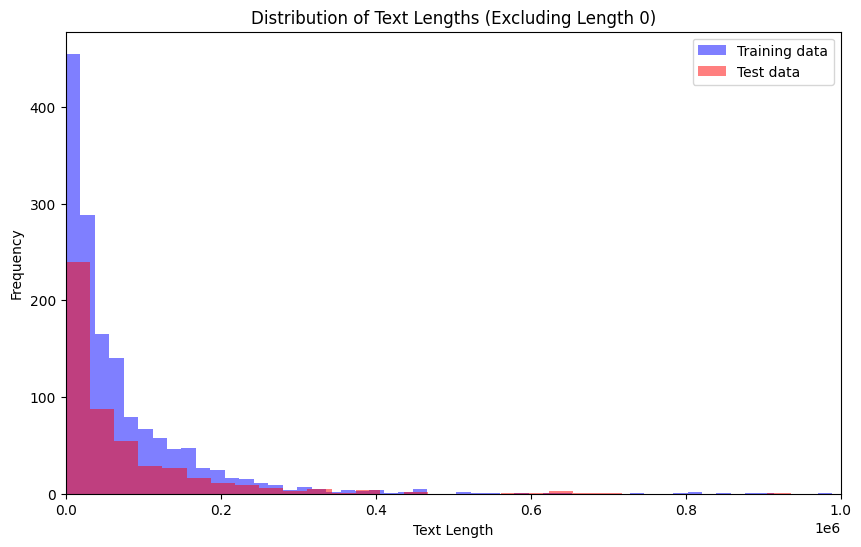

In [5]:
import matplotlib.pyplot as plt

# Filter out text entries with length 0
filtered_train_data_lengths = [length for length in train_data_lengths if length > 0]
filtered_test_data_lengths = [length for length in test_data_lengths if length > 0]

# Plot histograms of filtered text lengths
plt.figure(figsize=(10, 6))
plt.hist(filtered_train_data_lengths, bins=100, alpha=0.5, color='blue', label='Training data')
plt.hist(filtered_test_data_lengths, bins=100, alpha=0.5, color='red', label='Test data')
plt.title('Distribution of Text Lengths (Excluding Length 0)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(0, 1e6)
# plt.ylim(0, 2)
plt.show()


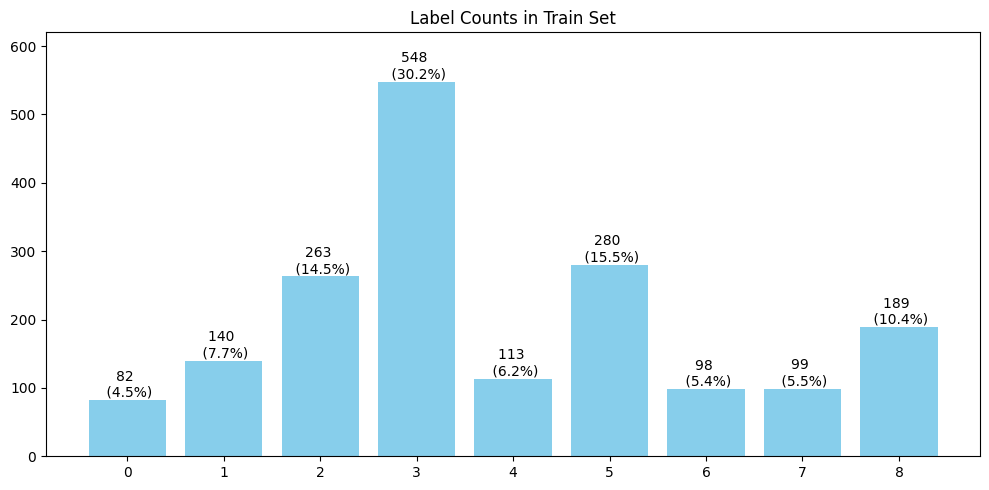

In [26]:
# Compute label counts and percentages
label_counts = np.unique(y_train, return_counts=True)
labels, counts = label_counts
total_samples = len(y_train)
percentages = (counts / total_samples) * 100

# Plot the bar plot
plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color='skyblue')

# Annotate each bar with count and percentage
for label, count, percent in zip(labels, counts, percentages):
    plt.text(label, count + 0.5, f'{count} \n ({percent:.1f}%)', ha='center', va='bottom')

plt.title('Label Counts in Train Set')
plt.ylim((0,620))
plt.tight_layout()
plt.show()


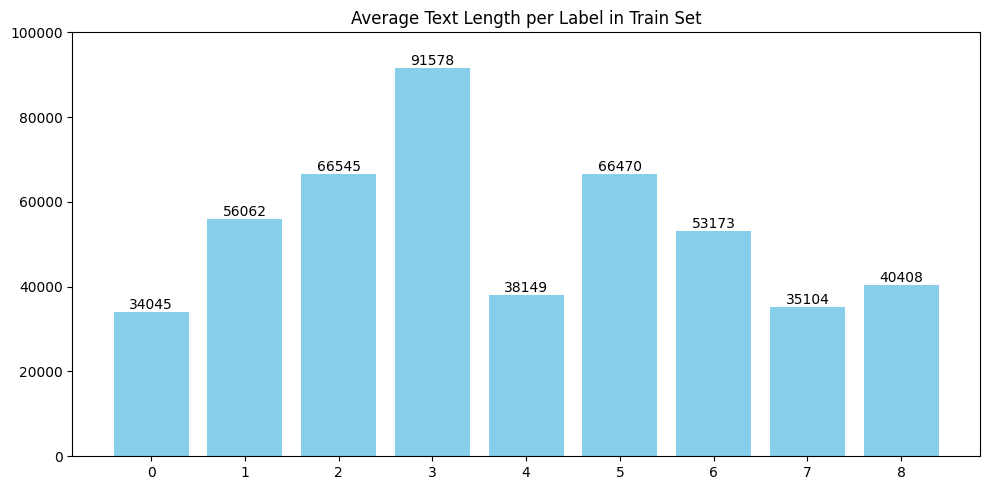

In [32]:
# Compute the average text length per label
label_lengths = {}
for label, length in zip(y_train, train_data_lengths):
    if label not in label_lengths:
        label_lengths[label] = []
    label_lengths[label].append(length)

# Calculate the average text length for each label
average_lengths = {label: np.mean(lengths) for label, lengths in label_lengths.items()}

# Sort the dictionary by keys (labels) in ascending order
sorted_average_lengths = dict(sorted(average_lengths.items()))

# Plot the bar plot
plt.figure(figsize=(10, 5))
plt.bar(sorted_average_lengths.keys(), sorted_average_lengths.values(), color='skyblue')

# Annotate each bar with the average text length
for label, length in sorted_average_lengths.items():
    plt.text(label, length + 0.5, f'{length:.0f}', ha='center', va='bottom')

plt.title('Average Text Length per Label in Train Set')
plt.ylim((0,100000))
plt.tight_layout()
plt.show()

## Preprocessing Function

In [32]:
def preprocess_text(text):
    
    # Convert to Lower Case
    text = text.lower()  
    
    # Replace line breaks, underscores, and *#* with space
    text = text.replace('\n', ' ').replace('*#*', ' ').replace(r'[-_]', ' ')
    
    # Remove html tags
    text = re.sub(r'\S*https?:\S*','', text)
    
    # Remove punctuation
    text = re.sub(r'<.*?>', ' ', text)
    
    # Remove numbers
    text = re.sub(r'\d+', ' ', text)
    
    # Remove any symbols
    text = re.sub(r'\W', ' ', text)
    
    # Keep only characters
    text = re.sub(r'[^A-Ωα-ωάΆώίέήόύ]', ' ', text)
    
    # Remove words three letters and below
    text = re.sub(r'\b\w{1,3}\b', '', text)
    
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Use spaCy for part-of-speech tagging and lemmatization
    nlp = spacy.load("el_core_news_sm")
    nlp.max_length = max(max_length_train, max_length_test)
    doc = nlp(text)
    tokens = [token.lemma_ if token.pos_ != "PROPN" else token.text for token in doc]                
                
    # Remove Stop Words
    stop_words = set(stopwords.words('greek'))
    tokens = [w for w in tokens if not w in stop_words]        
            
    # Re-forming the sentences
    text = ' '.join(tokens)
    
    return text

## Create Train & Test Data Frames

In [33]:
start_time = datetime.now()

# Retrieve textual content of domain names of the training set
train_data = list()
for domain in train_domains:
    if domain in text:
        train_data.append((domain, preprocess_text(text[domain])))
    else:
        train_data.append((domain, 'No textual information'))

# Retrieve textual content of domain names of the test set
test_data = list()

for domain in test_domains:
    if domain in text:
        test_data.append((domain, preprocess_text(text[domain])))
    else:
        test_data.append((domain, 'No textual information'))


print('The total processing execution time was:', datetime.now() - start_time) 

The total processing execution time was: 0:48:54.862667


In [48]:
# To reduce memory 
text = None  

In [35]:
# Create DataFrame for training data
train_df = pd.DataFrame({'domain': train_domains,
                         'text': [item[1] for item in train_data],
                         'label': y_train})

# Create DataFrame for test data
test_df = pd.DataFrame({'domain': [item[0] for item in test_data], 
                        'text': [item[1] for item in test_data]})


In [83]:
print(train_df.shape)
train_df.head()

(1812, 3)


,domain,text,label
0,autocarnet.gr,συμπληρώστε ερωτηματολόγιο αξιοπιστίας αυτοκ...,0
1,queen.gr,νικολέττα ράλλη μεταφέρω εμπειρία φωτογραφία...,5
2,aggeliorama.gr,εξοπλισμός επιχείρηση πάτρα αχαΐα ελλάδα πωλ...,5
3,bikerspoint.gr,προτείνω ένας φίλος ζελατίνας καλάθις έχω κα...,0
4,athensgo.gr,γυναίκα ψήφισαν αυτός είμαι σημείο οποίος λα...,3


In [84]:
print(test_df.shape)
test_df.head()

(605, 2)


,domain,text
0,startupper.gr,είστε εκατ ευρώ χρηματοδότηση εκατ ευρώ χρημ...
1,artware.gr,ελληνικα σχεδίαση ετικέτα κρασιού δημοσιευνω...
2,oneirokritis.blogspot.gr,ονειρα κόσμος συναισθήματος μέσα έχω επίδρασ...
3,kali-ellada.blogspot.gr,σε ο πλατανιά απέδειξαν όνειρα γίνομαι πραγμ...
4,ote.gr,No textual information


## Export clean data to csv

In [85]:
# Write preprocessed data frames to a CSV files
train_df.to_csv('preprocessed_train_data.csv', index=False)
test_df.to_csv('preprocessed_test_data.csv', index=False)